In [13]:
import pickle

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sklearn.cluster as cls

In [14]:
## Load road graph
road_graph: nx.DiGraph
with open("road_graph_nsl_wc.pickle", mode="rb") as file:
    road_graph = pickle.load(file)
print(road_graph)

## Load camera info
cameras_dict: dict
with open("cameras_info.pickle", mode="rb") as file:
    cameras_dict = pickle.load(file)

DiGraph with 8256 nodes and 10167 edges


[571665, 1710197, 749856, 1861632]


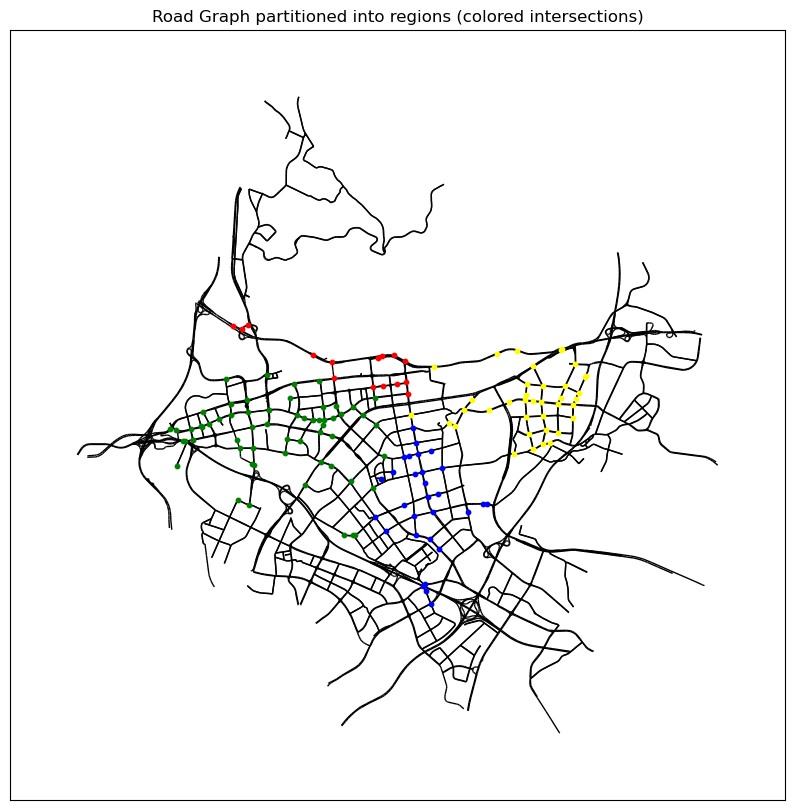

In [15]:
## Cluster nodes into regions
nodes = [{"node_id": node[0], "x": node[1]["pos"][0], "y": node[1]["pos"][1]} for node in road_graph.nodes(data=True)]
node_coordinates = np.array([[node["x"], node["y"]] for node in nodes])

seed = 0
number_of_regions = 4
k_means = cls.BisectingKMeans(number_of_regions, random_state=seed)
regions = k_means.fit_predict(node_coordinates)


def get_number_of_records_for_node(node_id):
    number_of_records = 0
    for camera in cameras_dict.values():
        if node_id == camera["node_id"]:
            number_of_records += camera["records"]
    return number_of_records


weights = np.array([get_number_of_records_for_node(node["node_id"]) for node in nodes])
region_weights = [0 for _ in set(regions)]
for region, weight in zip(regions, weights):
    region_weights[region] += weight
print(region_weights)

## Visualize regions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
pos = nx.get_node_attributes(road_graph, "pos")

camera_nodes = {camera["node_id"] for camera in cameras_dict.values()}

nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    ax=ax
)

node_sets = [set() for _ in range(number_of_regions)]
for index, node in zip(regions, nodes):
    node_sets[index].add(node["node_id"])

colors = ["red", "green", "blue", "yellow"]
for color, node_set in zip(colors, node_sets):
    nx.draw_networkx_nodes(
        road_graph,
        pos,
        node_color=color,
        node_size=10,
        nodelist=node_set.intersection(camera_nodes),
        ax=ax
    )
ax.set_title("Road Graph partitioned into regions (colored intersections)")

plt.show()

[1041900, 1659708, 1265017, 926725]


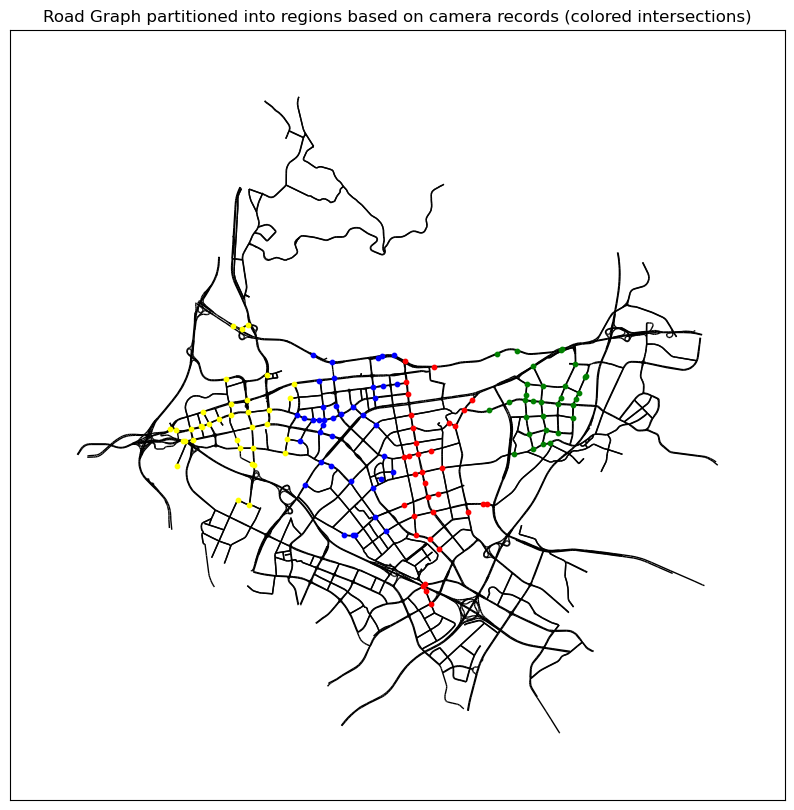

In [16]:
## Cluster nodes into regions based on camera records
k_means_weighted = cls.BisectingKMeans(number_of_regions, random_state=seed)
regions = k_means_weighted.fit_predict(node_coordinates, sample_weight=weights)

region_weights = [0 for _ in set(regions)]
for region, weight in zip(regions, weights):
    region_weights[region] += weight
print(region_weights)

# Visualize regions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
pos = nx.get_node_attributes(road_graph, "pos")

nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    ax=ax
)

node_sets = [set() for _ in range(number_of_regions)]
for index, node in zip(regions, nodes):
    node_sets[index].add(node["node_id"])

colors = ["red", "green", "blue", "yellow"]
for color, node_set in zip(colors, node_sets):
    nx.draw_networkx_nodes(
        road_graph,
        pos,
        node_color=color,
        node_size=10,
        nodelist=node_set.intersection(camera_nodes),
        ax=ax
    )
ax.set_title("Road Graph partitioned into regions based on camera records (colored intersections)")

plt.show()